# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.4.1


# Загружаем разметку

In [2]:
import os
import json
from glob import glob
from collections import defaultdict

TRAIN_PREFIX = 'data/fish/train'

def load_annotations():
    annotation = defaultdict(list)
    for path in glob('data/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for ann in json.load(src):
                basename = os.path.basename(ann['filename'])
                filename = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in ann['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                    rect['class'] = label
                    annotation[filename].append(rect)
    return annotation

def draw_boxes(filename, boxes, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(filename, cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, boxes, scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [3]:
annotations = load_annotations()  # загружаем разметку детекций

In [4]:
from collections import Counter
Counter([x['class'] for file in annotations.values() for x in file])

Counter({'shark': 196,
         'lag': 101,
         'yft': 823,
         'bet': 307,
         'dol': 124,
         'alb': 2531})

In [5]:
class OneHotEncoder:
    def __init__(self, categories=None):
        if not categories is None:
            self.fit(categories)
        else: self.categories = None
    
    def fit(self, categories):
        self.categories = list(set(categories))
    
    def transform(self, cat):
        if self.categories is None: 
            raise Exception('Not fitted!')
        res = np.zeros(len(self.categories))
        res[self.categories.index(cat)] = 1.
        return res
    
    def inverse_transform(self, oh_cat):
        return self.categories[np.argmax(oh_cat)]
    
    def __len__(self):
        if self.categories is None: 
            raise Exception('Not fitted!')
        return len(self.categories)
    
class_encoder = OneHotEncoder([x['class'] for file in annotations.values() for x in file])
n_classes = len(class_encoder)

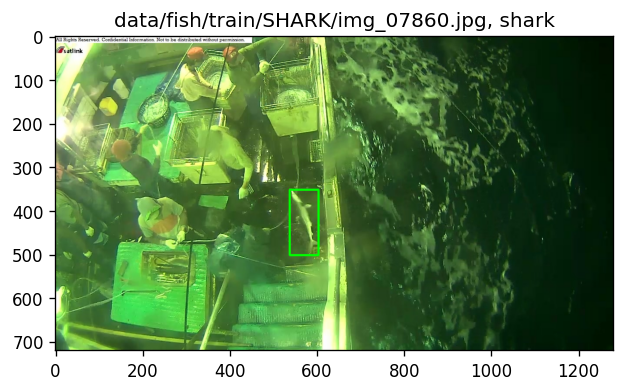

In [6]:
from matplotlib import pyplot as plt

filename = 'data/fish/train/SHARK/img_07860.jpg'
img = draw_boxes(filename, annotations[filename])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title(f"{filename}, {','.join(x['class'] for x in annotations[filename])}");

### Распределение размеров разметки

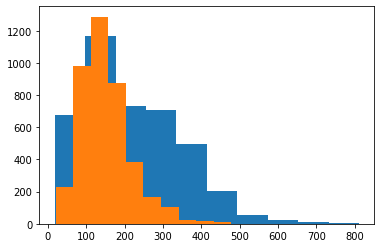

In [7]:
widths = [rect['width'] for rects in annotations.values() for rect in rects]
heights = [rect['height'] for rects in annotations.values() for rect in rects]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [8]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [9]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [10]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], n_classes+5), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            
            encoded[row, col][0] = 1.
            encoded[row, col][1:n_classes+1] = class_encoder.transform(rect['class'])
            encoded[row, col][-4:] = dx, dy, dw, dh
            
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            preds = prediction[row, col]
            conf = _sigmoid(preds[0])
            class_logits = preds[1:n_classes+1]
            dx, dy, dw, dh = preds[-4:]
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'class_logits': class_logits})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

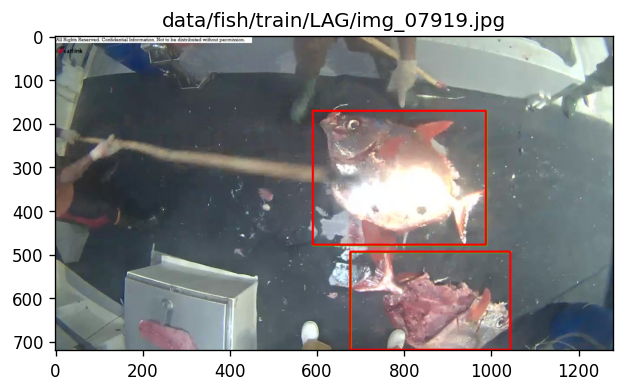

In [11]:
filename = 'data/fish/train/LAG/img_07919.jpg'
annotation = annotations[filename]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(filename, annotation, decoded))
plt.title(f"{filename}");

## Функция потерь

In [12]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., -4:] - y_pred[..., -4:])
    square_loss = 0.5 * K.square(y_true[..., -4:] - y_pred[..., -4:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def classification_loss(y_true, y_pred):
    total_loss = K.categorical_crossentropy(y_true[...,1:n_classes+1], 
                                            y_pred[...,1:n_classes+1], 
                                            from_logits=True)
    return total_loss

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    
    y_true = K.reshape(y_true, (batch_size, -1, n_classes+5))
    y_pred = K.reshape(y_pred, (batch_size, -1, n_classes+5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # TODO: добавьте функцию потерь для классификации детекции - Done!
    cls_loss = K.sum(classification_loss(y_true, y_pred) * y_true[..., 0], axis=-1) # нас интересует правильная классификация только внутри анкоров
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss + cls_loss

## Загрузка данных

In [13]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(annotations, batch_size=32):
    filenames = list(annotations.keys())
    while True:
        shuffle(filenames)
        for i in range(len(filenames)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                filename = filenames[j]
                annotation = annotations[filename]
                img_shape, img = load_img(filename)
                # TODO: добавьте one-hot encoding в разметку для классов
                y.append(encode_anchors(annotation, img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [14]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(5+n_classes,
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 750, 1200, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 187, 300, 128)     0     

## Обучение

In [15]:
adam = tf.keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss])

In [16]:
batch_size = 5

gen = data_generator(annotations, batch_size=batch_size)
steps_per_epoch = sum(map(len, annotations.values())) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          callbacks=[checkpoint])

Epoch 1/100
 10/816 [..............................] - ETA: 4:22 - loss: 13.3998 - confidence_loss: 0.9175
Epoch 00001: loss improved from inf to 11.21161, saving model to fishdetector.hdf5
 20/816 [..............................] - ETA: 4:42 - loss: 11.6658 - confidence_loss: 0.9140
Epoch 00001: loss improved from 11.21161 to 9.28869, saving model to fishdetector.hdf5
 30/816 [>.............................] - ETA: 4:40 - loss: 10.5069 - confidence_loss: 0.8972
Epoch 00001: loss improved from 9.28869 to 7.58245, saving model to fishdetector.hdf5
 40/816 [>.............................] - ETA: 4:39 - loss: 9.6871 - confidence_loss: 0.8808
Epoch 00001: loss improved from 7.58245 to 6.99020, saving model to fishdetector.hdf5
 50/816 [>.............................] - ETA: 4:58 - loss: 9.0840 - confidence_loss: 0.8649
Epoch 00001: loss improved from 6.99020 to 6.42720, saving model to fishdetector.hdf5
 60/816 [=>............................] - ETA: 5:08 - loss: 8.6081 - confidence_loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



117/816 [===>..........................] - ETA: 4:04 - loss: 0.2283 - confidence_loss: 0.0099
Epoch 00010: loss did not improve from 0.21906
127/816 [===>..........................] - ETA: 3:59 - loss: 0.2279 - confidence_loss: 0.0099
Epoch 00010: loss did not improve from 0.21906
137/816 [====>.........................] - ETA: 3:54 - loss: 0.2275 - confidence_loss: 0.0099
Epoch 00010: loss did not improve from 0.21906
147/816 [====>.........................] - ETA: 3:50 - loss: 0.2273 - confidence_loss: 0.0098
Epoch 00010: loss did not improve from 0.21906
157/816 [====>.........................] - ETA: 3:45 - loss: 0.2274 - confidence_loss: 0.0098
Epoch 00010: loss did not improve from 0.21906
167/816 [=====>........................] - ETA: 3:42 - loss: 0.2277 - confidence_loss: 0.0098
Epoch 00010: loss did not improve from 0.21906
177/816 [=====>........................] - ETA: 3:37 - loss: 0.2282 - confidence_loss: 0.0098
Epoch 00010: loss did not improve from 0.21906
187/816 [====

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



268/816 [========>.....................] - ETA: 2:57 - loss: 0.1018 - confidence_loss: 0.0036
Epoch 00017: loss did not improve from 0.05959
278/816 [=========>....................] - ETA: 2:54 - loss: 0.1017 - confidence_loss: 0.0036
Epoch 00017: loss did not improve from 0.05959
288/816 [=========>....................] - ETA: 2:51 - loss: 0.1015 - confidence_loss: 0.0036
Epoch 00017: loss did not improve from 0.05959
298/816 [=========>....................] - ETA: 2:48 - loss: 0.1014 - confidence_loss: 0.0035
Epoch 00017: loss did not improve from 0.05959
308/816 [==========>...................] - ETA: 2:44 - loss: 0.1012 - confidence_loss: 0.0035
Epoch 00017: loss did not improve from 0.05959
318/816 [==========>...................] - ETA: 2:41 - loss: 0.1011 - confidence_loss: 0.0035
Epoch 00017: loss did not improve from 0.05959
328/816 [===========>..................] - ETA: 2:38 - loss: 0.1010 - confidence_loss: 0.0035
Epoch 00017: loss did not improve from 0.05959
338/816 [====

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



459/816 [===============>..............] - ETA: 1:55 - loss: 0.0582 - confidence_loss: 0.0018
Epoch 00024: loss did not improve from 0.03611
469/816 [================>.............] - ETA: 1:52 - loss: 0.0582 - confidence_loss: 0.0018
Epoch 00024: loss did not improve from 0.03611
479/816 [================>.............] - ETA: 1:49 - loss: 0.0582 - confidence_loss: 0.0018
Epoch 00024: loss did not improve from 0.03611
489/816 [================>.............] - ETA: 1:46 - loss: 0.0582 - confidence_loss: 0.0018
Epoch 00024: loss did not improve from 0.03611
499/816 [=================>............] - ETA: 1:43 - loss: 0.0582 - confidence_loss: 0.0018
Epoch 00024: loss did not improve from 0.03611
509/816 [=================>............] - ETA: 1:39 - loss: 0.0582 - confidence_loss: 0.0018
Epoch 00024: loss did not improve from 0.03611
519/816 [==================>...........] - ETA: 1:36 - loss: 0.0582 - confidence_loss: 0.0018
Epoch 00024: loss did not improve from 0.03611
529/816 [====

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



510/816 [=================>............] - ETA: 1:38 - loss: 0.1748 - confidence_loss: 0.0026
Epoch 00031: loss did not improve from 0.02757
520/816 [==================>...........] - ETA: 1:35 - loss: 0.1739 - confidence_loss: 0.0026
Epoch 00031: loss did not improve from 0.02757
530/816 [==================>...........] - ETA: 1:32 - loss: 0.1731 - confidence_loss: 0.0026
Epoch 00031: loss did not improve from 0.02757
540/816 [==================>...........] - ETA: 1:29 - loss: 0.1723 - confidence_loss: 0.0026
Epoch 00031: loss did not improve from 0.02757
550/816 [===================>..........] - ETA: 1:26 - loss: 0.1715 - confidence_loss: 0.0026
Epoch 00031: loss did not improve from 0.02757
560/816 [===================>..........] - ETA: 1:22 - loss: 0.1707 - confidence_loss: 0.0026
Epoch 00031: loss did not improve from 0.02757
570/816 [===================>..........] - ETA: 1:19 - loss: 0.1699 - confidence_loss: 0.0026
Epoch 00031: loss did not improve from 0.02757
580/816 [====

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



158/816 [====>.........................] - ETA: 3:32 - loss: 0.0314 - confidence_loss: 0.0013
Epoch 00037: loss did not improve from 0.02267
168/816 [=====>........................] - ETA: 3:29 - loss: 0.0317 - confidence_loss: 0.0013
Epoch 00037: loss did not improve from 0.02267
178/816 [=====>........................] - ETA: 3:26 - loss: 0.0319 - confidence_loss: 0.0013
Epoch 00037: loss did not improve from 0.02267
181/816 [=====>........................] - ETA: 3:25 - loss: 0.0320 - confidence_loss: 0.0013

KeyboardInterrupt: 

## Результат работы детектора

In [17]:
model.load_weights('fishdetector.hdf5')

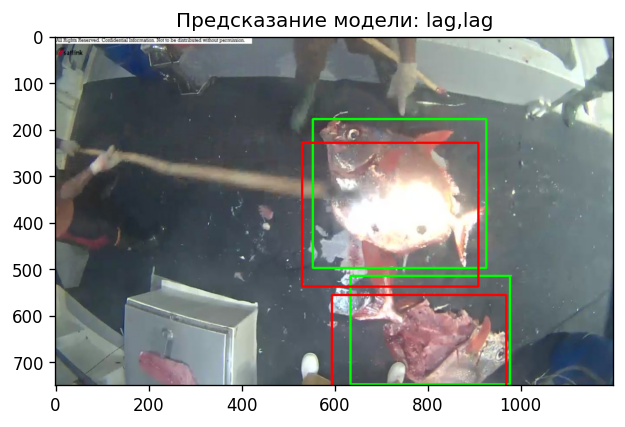

In [18]:
filename = 'data/fish/train/LAG/img_07919.jpg'

annotation = annotations[filename]

_, sample_img = load_img(filename)
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=1e-1)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(filename, annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
pred_classes = [class_encoder.inverse_transform(dec['class_logits']) for dec in decoded]
plt.title(f'Предсказание модели: {",".join(pred_classes)}');

## Визуализируем предсказание на тесте

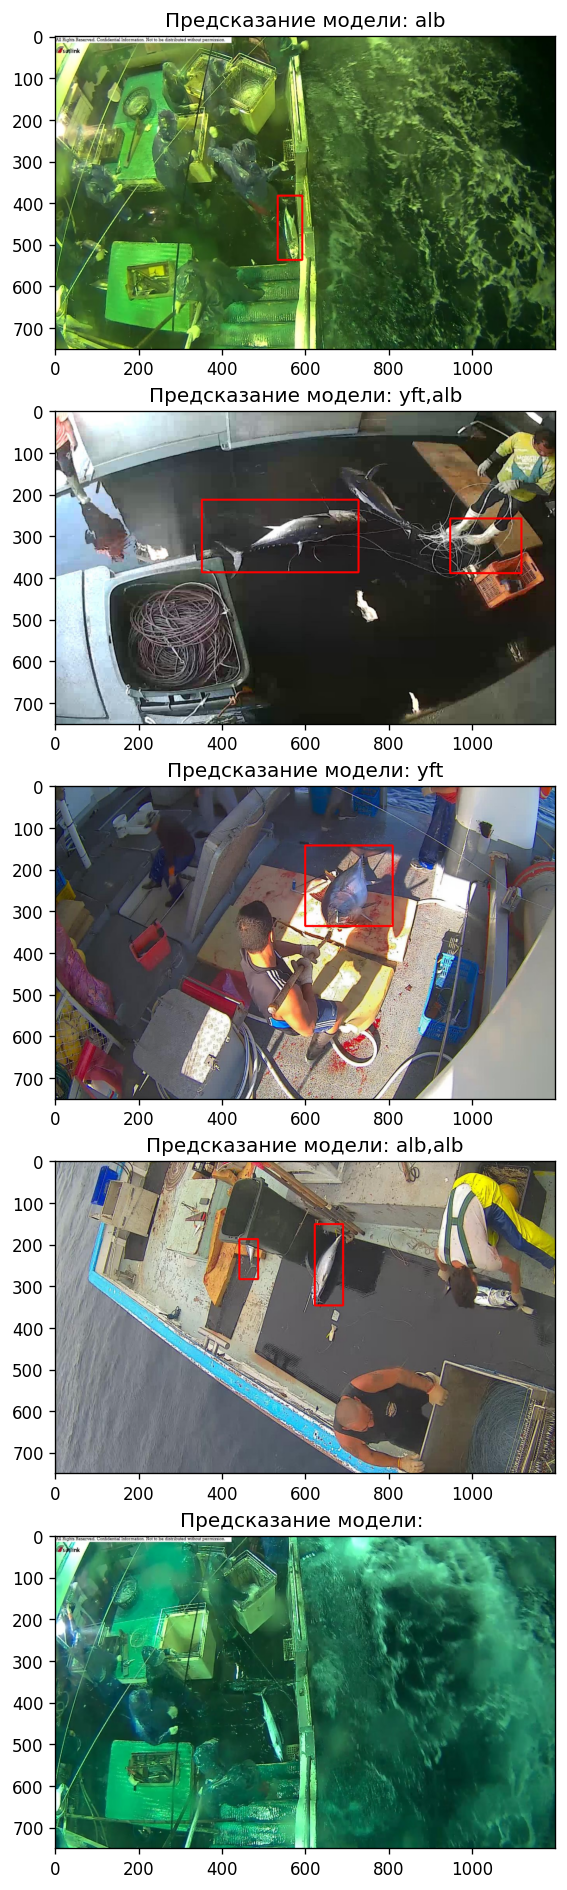

In [21]:
test_images = glob('data/fish/test_stg1/*.jpg')[:5]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    plt.subplot(len(test_images), 1, i + 1)
    
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=1e-2)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
    
    img = draw_boxes(filename, [], decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    pred_classes = [class_encoder.inverse_transform(dec['class_logits']) for dec in decoded]
    plt.title(f'Предсказание модели: {",".join(pred_classes)}');

## Агрегация результатов

In [22]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

In [25]:
from scipy.special import softmax
from tqdm.auto import tqdm

test_filenames = list(glob('data/fish/test_stg1/*.jpg')) + list(glob('data/fish/test_stg2/*.jpg'))
res = []
for i, filename in tqdm(enumerate(test_filenames), total=len(test_filenames)):
    _, sample_img = load_img(filename)
    
    pred = model.predict(np.array([sample_img,]))
    decoded = decode_prediction(pred[0], conf_thr=0.01)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
    filename = filename.split('/')[-1]
    if len(decoded) == 0:
        res.append([filename] + [0.]*n_classes + [0., 1.]) # нет рыбы
        continue;
    preds = softmax(decoded[np.argmax([x['conf'] for x in decoded])]['class_logits']).tolist()
    other_threshold = 0.8 # если максимальное предсказание класса меньше этого трешхолда, предсказываем другую рыбу
    if max(preds) < other_threshold:
        res.append([filename] + [0.]*n_classes + [1., 0.]) # другая рыба
        continue;
    else:
        res.append([filename] + preds + [0., 0.])
res = pd.DataFrame(res, columns=['image'] + [cat.upper() for cat in class_encoder.categories] + ['OTHER', 'NoF'])['image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT'.split(',')]
res

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_04037.jpg,0.999232,9.822352e-05,1.236924e-04,8.594664e-05,0.0,0.0,2.643387e-04,1.962578e-04
1,img_03452.jpg,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,0.000000e+00,0.000000e+00
2,img_01102.jpg,0.066294,2.335827e-03,1.700826e-03,1.172488e-03,0.0,0.0,1.156048e-03,9.273412e-01
3,img_05950.jpg,0.999999,5.218224e-07,5.870944e-08,7.605453e-08,0.0,0.0,8.179343e-08,1.960558e-08
4,img_02209.jpg,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...
13148,image_02587.jpg,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0,0.000000e+00,0.000000e+00
13149,image_06703.jpg,0.944590,8.182399e-03,8.939133e-03,7.982033e-03,0.0,0.0,5.359454e-03,2.494727e-02
13150,image_05994.jpg,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0,0.000000e+00,0.000000e+00
13151,image_03260.jpg,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0,0.000000e+00,0.000000e+00


In [27]:
def format_path(path:str):
    if 'img' in path: return path
    return 'test_stg2/' + path

res['image'] = res['image'].apply(format_path)

In [30]:
res

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_04037.jpg,0.999232,9.822352e-05,1.236924e-04,8.594664e-05,0.0,0.0,2.643387e-04,1.962578e-04
1,img_03452.jpg,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,0.000000e+00,0.000000e+00
2,img_01102.jpg,0.066294,2.335827e-03,1.700826e-03,1.172488e-03,0.0,0.0,1.156048e-03,9.273412e-01
3,img_05950.jpg,0.999999,5.218224e-07,5.870944e-08,7.605453e-08,0.0,0.0,8.179343e-08,1.960558e-08
4,img_02209.jpg,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...
13148,test_stg2/image_02587.jpg,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0,0.000000e+00,0.000000e+00
13149,test_stg2/image_06703.jpg,0.944590,8.182399e-03,8.939133e-03,7.982033e-03,0.0,0.0,5.359454e-03,2.494727e-02
13150,test_stg2/image_05994.jpg,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0,0.000000e+00,0.000000e+00
13151,test_stg2/image_03260.jpg,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0,0.000000e+00,0.000000e+00


In [28]:
res.to_csv('submission.csv', index=None)

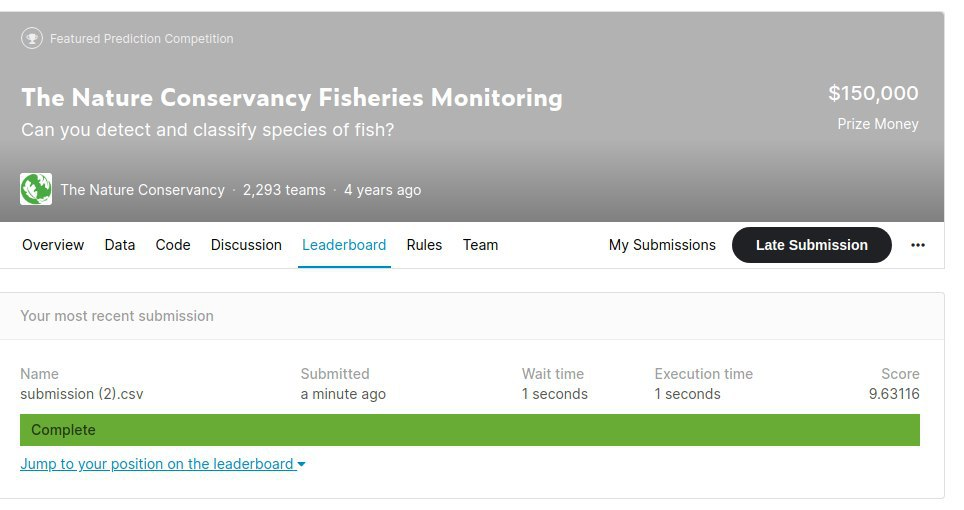

In [29]:
from IPython.display import Image
Image('Romantsova.jpg')